In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
from transformers import pipeline
from transformers import AutoTokenizer, ModernBertForSequenceClassification

import torch.nn.functional as F

In [12]:
import torch
import torch.nn.functional as F
from transformers import ModernBertForSequenceClassification, AutoTokenizer


class ModernBERTBayesianEarlyExit:
    def __init__(
        self,
        model_name="answerdotai/ModernBERT-base",
        exit_layers=[5, 10, 15, 20],
        dropout_passes=10,          # Number of MC samples
        uncertainty_threshold=0.02, # Lower = more confident
        use_entropy=False           # use variance (default) or entropy
    ):
        self.device = "cpu"

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.model = ModernBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )
        self.model.to(self.device)
        self.model.eval()  # BUT dropout will still work because we unfreeze it manually later

        # Extract structure
        self.embeddings = self.model.model.embeddings
        self.layers = self.model.model.layers
        self.final_norm = self.model.model.final_norm
        self.classifier = self.model.classifier

        self.exit_layers = sorted(exit_layers)
        self.dropout_passes = dropout_passes
        self.uncertainty_threshold = uncertainty_threshold
        self.use_entropy = use_entropy
        self.num_layers = len(self.layers)

        # Enable dropout modules even in eval mode
        self._enable_dropout(self.model)

    def _enable_dropout(self, module):
        """Force dropout modules to stay active even in eval mode (Bayesian trick)."""
        for m in module.modules():
            if isinstance(m, torch.nn.Dropout):
                m.train()

    # ---------- Bayesian uncertainty metrics ----------
    def predictive_variance(self, probs_mc):
        """
        probs_mc: shape [K, num_classes]
        Returns scalar uncertainty = variance of predicted probability for predicted class
        """
        mean_prob = probs_mc.mean(dim=0)             # [num_classes]
        var = ((probs_mc - mean_prob)**2).mean(dim=0)
        pred_class = torch.argmax(mean_prob).item()
        return var[pred_class].item(), mean_prob, pred_class

    def predictive_entropy(self, probs):
        """
        probs: mean probability vector
        Entropy = -sum(p log p)
        """
        entropy = -(probs * torch.log(probs + 1e-12)).sum().item()
        return entropy

    @torch.no_grad()
    def classify(self, text):
        enc = self.tokenizer(text, return_tensors="pt", truncation=True, padding=False)
        input_ids = enc["input_ids"].to(self.device)

        attention_mask = (enc["attention_mask"] == 1).to(self.device)
        position_ids = torch.arange(
            0, input_ids.size(1), dtype=torch.long, device=self.device
        ).unsqueeze(0)

        hidden = self.embeddings(input_ids)

        # Manual forward block by block
        for i, layer in enumerate(self.layers):

            hidden = layer(
                hidden_states=hidden,
                attention_mask=attention_mask,
                position_ids=position_ids,
            )[0]

            # ---- BAYESIAN EXIT LAYER ----
            if i in self.exit_layers:

                cls = hidden[:, 0, :]  # CLS embedding

                # MONTE CARLO DROPOUT
                probs_mc = []
                for _ in range(self.dropout_passes):
                    logits = self.classifier(cls)
                    probs_mc.append(F.softmax(logits, dim=-1))

                probs_mc = torch.stack(probs_mc, dim=0).squeeze(1)   # FIX: remove batch dim

                # Bayesian uncertainty (variance)
                var, mean_prob, pred_class = self.predictive_variance(probs_mc)

                # Alternatively use entropy
                if self.use_entropy:
                    entropy = self.predictive_entropy(mean_prob)
                    unc_value = entropy
                else:
                    unc_value = var

                # EXIT RULE
                if unc_value <= self.uncertainty_threshold:
                    conf = mean_prob[pred_class].item()
                    return pred_class, i + 1, conf, unc_value

        # Final layer (if no early exit)
        hidden = self.final_norm(hidden)
        cls = hidden[:, 0, :]
        logits = self.classifier(cls)
        final_probs = F.softmax(logits, dim=-1)[0]
        conf, final_pred = torch.max(final_probs, dim=0)

        return final_pred.item(), self.num_layers, conf.item(), 0.0

In [4]:
class ModernBERTBaselineClassifier:
    def __init__(self, model_name="answerdotai/ModernBERT-base"):
        # Detect device: MPS (Apple Silicon) → else CPU
        self.device = "cpu"

        # Load tokenizer + classification model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = ModernBertForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        # ModernBERT layer count (22 for base)
        self.num_layers = self.model.config.num_hidden_layers

    @torch.no_grad()
    def classify(self, text):
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=False
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Forward pass
        outputs = self.model(**inputs)
        logits = outputs.logits  # [1, num_labels]

        # Softmax for confidence
        probs = F.softmax(logits, dim=-1)[0]
        conf, pred = torch.max(probs, dim=0)

        return pred.item(), (self.num_layers - 1), conf.item(), None

In [5]:
import time
import numpy as np

from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.amazon import load_amazon_polarity
from evaluation.dataset_loaders.imdb import load_imdb
from evaluation.dataset_loaders.dbpedia import load_dbpedia
from evaluation.dataset_loaders.yanswers import load_yahoo

dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("imdb", load_imdb, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification")
]

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("\nAll datasets loaded.\n")

Loading datasets once...

Loading sst2...
Loading imdb...
Loading amazon_polarity...

All datasets loaded.



In [6]:
# Extract (text, label) from any format
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)

def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0
    uncertainties = []     # NEW

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        # Bayesian model returns 4 outputs
        # Baseline model: pred, layer, conf, unc=None  (you already fixed baseline)
        pred, layer, conf, unc = model.classify(text)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)
        uncertainties.append(unc if unc is not None else 0.0)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "avg_uncertainty": float(np.mean(uncertainties)),   # NEW
        "num_samples": total
    }

In [8]:
results_table = []

print("Running BASELINE")

baseline_model = ModernBERTBaselineClassifier()

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })

Running BASELINE


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.508, 'avg_latency_sec': 0.04796639823913574, 'tokens_per_sec': 542.6715566640596, 'avg_layers_used': 21.0, 'avg_uncertainty': 0.0, 'num_samples': 500}

Testing BASELINE on imdb...
imdb {'metric': 'accuracy', 'score': 0.528, 'avg_latency_sec': 0.19430025577545165, 'tokens_per_sec': 1488.9944372196362, 'avg_layers_used': 21.0, 'avg_uncertainty': 0.0, 'num_samples': 500}

Testing BASELINE on amazon_polarity...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.07481225967407226, 'tokens_per_sec': 1291.7134226529881, 'avg_layers_used': 21.0, 'avg_uncertainty': 0.0, 'num_samples': 500}


In [18]:
# -------------------------
# EARLY EXIT NEXT
# -------------------------
exit_layer_groups = [
    [2, 4, 6, 8, 10],
    [4, 8],
    [3, 6, 9],
    [6]
]

thresholds = [0.005, 0.01, 0.02, 0.05, 0.1]

for exit_layers in exit_layer_groups:

    print("\n=================================================")
    print(f"Testing EXIT LAYERS: {exit_layers}")
    print("=================================================")

    for th in thresholds:

        print(f"\n----------------------------")
        print(f"Threshold = {th}")
        print(f"Exit Layers = {exit_layers}")
        print("----------------------------")

        # Create modernbert early exit model
        model = ModernBERTBayesianEarlyExit(
            model_name="answerdotai/ModernBERT-base",
            exit_layers=exit_layers,
            dropout_passes=10,
            uncertainty_threshold=th,
            use_entropy=False
        )

        # Evaluate across datasets
        for name, meta in cached_datasets.items():
            dataset = meta["data"]

            print(f"\nTesting {name} (exit_layers={exit_layers}, threshold={th})...")

            result = evaluate_dataset(model, dataset, name)
            print(name, result)

            # Save results with exit_layers column added
            results_table.append({
                "dataset": name,
                "threshold": th,
                "exit_layers": str(exit_layers),
                "mode": "early_exit",
                "metric": result["metric"],
                "score": float(result["score"]),
                "tokens_per_sec": float(result["tokens_per_sec"]),
                "avg_latency_sec": float(result["avg_latency_sec"]),
                "avg_layers_used": float(result["avg_layers_used"]),
                "avg_uncertainty": float(result["avg_uncertainty"]),
                "num_samples": int(result["num_samples"]),
            })



Testing EXIT LAYERS: [2, 4, 6, 8, 10]

----------------------------
Threshold = 0.005
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.005)...
sst2 {'metric': 'accuracy', 'score': 0.546, 'avg_latency_sec': 0.004455510139465332, 'tokens_per_sec': 5842.204188794336, 'avg_layers_used': 3.0, 'avg_uncertainty': 2.842170943040401e-17, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.005)...
imdb {'metric': 'accuracy', 'score': 0.52, 'avg_latency_sec': 0.01574358606338501, 'tokens_per_sec': 18376.499409677403, 'avg_layers_used': 3.0, 'avg_uncertainty': 2.913225216616411e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.005)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.006005668640136718, 'tokens_per_sec': 16090.7978429193, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.0658141036401502e-16, 'num_samples': 500}

----------------------------
Threshold = 0.01
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.01)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.003718432426452637, 'tokens_per_sec': 7000.261673393504, 'avg_layers_used': 3.0, 'avg_uncertainty': 4.689582056016661e-16, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.01)...
imdb {'metric': 'accuracy', 'score': 0.52, 'avg_latency_sec': 0.014292121887207031, 'tokens_per_sec': 20242.76047204474, 'avg_layers_used': 3.0, 'avg_uncertainty': 8.526512829121202e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.01)...
amazon_polarity {'metric': 'accuracy', 'score': 0.492, 'avg_latency_sec': 0.005955471992492676, 'tokens_per_sec': 16226.421704579756, 'avg_layers_used': 3.0, 'avg_uncertainty': 7.318590178329032e-16, 'num_samples': 500}

----------------------------
Threshold = 0.02
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.02)...
sst2 {'metric': 'accuracy', 'score': 0.51, 'avg_latency_sec': 0.004558373928070068, 'tokens_per_sec': 5710.36962099786, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.0587086762825492e-15, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.02)...
imdb {'metric': 'accuracy', 'score': 0.48, 'avg_latency_sec': 0.015276845932006835, 'tokens_per_sec': 18937.94054660566, 'avg_layers_used': 3.0, 'avg_uncertainty': 3.552713678800501e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.02)...
amazon_polarity {'metric': 'accuracy', 'score': 0.502, 'avg_latency_sec': 0.005562024116516113, 'tokens_per_sec': 17374.250448329578, 'avg_layers_used': 3.0, 'avg_uncertainty': 4.1211478674085813e-16, 'num_samples': 500}

----------------------------
Threshold = 0.05
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.05)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.003981695652008056, 'tokens_per_sec': 6537.415783366691, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.3926637620897964e-15, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.05)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.014255511283874511, 'tokens_per_sec': 20294.747360430538, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.4921397450962105e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.05)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.006052268028259277, 'tokens_per_sec': 15966.90687669263, 'avg_layers_used': 3.0, 'avg_uncertainty': 8.810729923425242e-16, 'num_samples': 500}

----------------------------
Threshold = 0.1
Exit Layers = [2, 4, 6, 8, 10]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[2, 4, 6, 8, 10], threshold=0.1)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.004265468120574951, 'tokens_per_sec': 6102.49549737377, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.4352963262354025e-15, 'num_samples': 500}

Testing imdb (exit_layers=[2, 4, 6, 8, 10], threshold=0.1)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.014950245857238769, 'tokens_per_sec': 19351.6550003703, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.3642420526593924e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[2, 4, 6, 8, 10], threshold=0.1)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.006561396598815918, 'tokens_per_sec': 14727.962034399676, 'avg_layers_used': 3.0, 'avg_uncertainty': 1.2363443602225742e-15, 'num_samples': 500}

Testing EXIT LAYERS: [4, 8]

----------------------------
Threshold = 0.005
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.005)...
sst2 {'metric': 'accuracy', 'score': 0.55, 'avg_latency_sec': 0.008353876113891602, 'tokens_per_sec': 3115.918843555137, 'avg_layers_used': 5.0, 'avg_uncertainty': 7.105427357601002e-18, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.005)...
imdb {'metric': 'accuracy', 'score': 0.538, 'avg_latency_sec': 0.02535229778289795, 'tokens_per_sec': 11411.667789543042, 'avg_layers_used': 5.0, 'avg_uncertainty': 4.9737991503207014e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.005)...
amazon_polarity {'metric': 'accuracy', 'score': 0.518, 'avg_latency_sec': 0.01214477014541626, 'tokens_per_sec': 7957.005265881697, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.4210854715202004e-17, 'num_samples': 500}

----------------------------
Threshold = 0.01
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.01)...
sst2 {'metric': 'accuracy', 'score': 0.458, 'avg_latency_sec': 0.009896987438201905, 'tokens_per_sec': 2630.0932644943477, 'avg_layers_used': 5.0, 'avg_uncertainty': 7.105427357601002e-18, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.01)...
imdb {'metric': 'accuracy', 'score': 0.5, 'avg_latency_sec': 0.02433825969696045, 'tokens_per_sec': 11887.127658356425, 'avg_layers_used': 5.0, 'avg_uncertainty': 6.181721801112871e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.01)...
amazon_polarity {'metric': 'accuracy', 'score': 0.52, 'avg_latency_sec': 0.010403124332427979, 'tokens_per_sec': 9289.13246751961, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.2789769243681802e-16, 'num_samples': 500}

----------------------------
Threshold = 0.02
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.02)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.007008798599243164, 'tokens_per_sec': 3713.9032647921736, 'avg_layers_used': 5.0, 'avg_uncertainty': 5.826450433232822e-16, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.02)...
imdb {'metric': 'accuracy', 'score': 0.476, 'avg_latency_sec': 0.026095905780792236, 'tokens_per_sec': 11086.49005825836, 'avg_layers_used': 5.0, 'avg_uncertainty': 6.110667527536861e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.02)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.009696648597717286, 'tokens_per_sec': 9965.91750501811, 'avg_layers_used': 5.0, 'avg_uncertainty': 4.618527782440651e-16, 'num_samples': 500}

----------------------------
Threshold = 0.05
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.05)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.0072827420234680175, 'tokens_per_sec': 3574.2032212757963, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.4352963262354025e-15, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.05)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.024613359928131105, 'tokens_per_sec': 11754.2668227648, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.4210854715202005e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.05)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.010757771492004395, 'tokens_per_sec': 8982.901344560418, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.2718714970105793e-15, 'num_samples': 500}

----------------------------
Threshold = 0.1
Exit Layers = [4, 8]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[4, 8], threshold=0.1)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.00806768560409546, 'tokens_per_sec': 3226.451956281762, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.3784529073745944e-15, 'num_samples': 500}

Testing imdb (exit_layers=[4, 8], threshold=0.1)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.026944353580474853, 'tokens_per_sec': 10737.3887867048, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.2008172234345694e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[4, 8], threshold=0.1)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.010267777919769287, 'tokens_per_sec': 9411.578703308318, 'avg_layers_used': 5.0, 'avg_uncertainty': 1.3713474800169934e-15, 'num_samples': 500}

Testing EXIT LAYERS: [3, 6, 9]

----------------------------
Threshold = 0.005
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.005)...
sst2 {'metric': 'accuracy', 'score': 0.49, 'avg_latency_sec': 0.00623520040512085, 'tokens_per_sec': 4174.685384389901, 'avg_layers_used': 4.0, 'avg_uncertainty': 2.842170943040401e-17, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.005)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.020561474323272703, 'tokens_per_sec': 14070.586352484432, 'avg_layers_used': 4.0, 'avg_uncertainty': 4.263256414560601e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.005)...
amazon_polarity {'metric': 'accuracy', 'score': 0.486, 'avg_latency_sec': 0.009769495487213134, 'tokens_per_sec': 9891.6059817503, 'avg_layers_used': 4.0, 'avg_uncertainty': 2.5579538487363605e-16, 'num_samples': 500}

----------------------------
Threshold = 0.01
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.01)...
sst2 {'metric': 'accuracy', 'score': 0.51, 'avg_latency_sec': 0.0070414643287658694, 'tokens_per_sec': 3696.6742689673156, 'avg_layers_used': 4.0, 'avg_uncertainty': 2.984279490192421e-16, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.01)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.02188718557357788, 'tokens_per_sec': 13218.328095561827, 'avg_layers_used': 4.0, 'avg_uncertainty': 1.2150280781497714e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.01)...
amazon_polarity {'metric': 'accuracy', 'score': 0.502, 'avg_latency_sec': 0.008871244430541993, 'tokens_per_sec': 10893.172965373471, 'avg_layers_used': 4.0, 'avg_uncertainty': 1.0302869668521452e-15, 'num_samples': 500}

----------------------------
Threshold = 0.02
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.02)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.006652019500732422, 'tokens_per_sec': 3913.097367969827, 'avg_layers_used': 4.0, 'avg_uncertainty': 9.876544027065393e-16, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.02)...
imdb {'metric': 'accuracy', 'score': 0.524, 'avg_latency_sec': 0.02037687397003174, 'tokens_per_sec': 14198.056111329493, 'avg_layers_used': 4.0, 'avg_uncertainty': 6.181721801112871e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.02)...
amazon_polarity {'metric': 'accuracy', 'score': 0.494, 'avg_latency_sec': 0.008094573497772217, 'tokens_per_sec': 11938.368343507671, 'avg_layers_used': 4.0, 'avg_uncertainty': 7.105427357601002e-16, 'num_samples': 500}

----------------------------
Threshold = 0.05
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.05)...
sst2 {'metric': 'accuracy', 'score': 0.508, 'avg_latency_sec': 0.006699122428894043, 'tokens_per_sec': 3885.5835635619646, 'avg_layers_used': 4.0, 'avg_uncertainty': 1.4921397450962105e-16, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.05)...
imdb {'metric': 'accuracy', 'score': 0.528, 'avg_latency_sec': 0.022092533588409423, 'tokens_per_sec': 13095.464983327398, 'avg_layers_used': 4.0, 'avg_uncertainty': 1.1581846592889633e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.05)...
amazon_polarity {'metric': 'accuracy', 'score': 0.494, 'avg_latency_sec': 0.008582508087158203, 'tokens_per_sec': 11259.645667516945, 'avg_layers_used': 4.0, 'avg_uncertainty': 3.907985046680551e-16, 'num_samples': 500}

----------------------------
Threshold = 0.1
Exit Layers = [3, 6, 9]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[3, 6, 9], threshold=0.1)...
sst2 {'metric': 'accuracy', 'score': 0.434, 'avg_latency_sec': 0.0065194697380065916, 'tokens_per_sec': 3992.656005173665, 'avg_layers_used': 4.0, 'avg_uncertainty': 0.0, 'num_samples': 500}

Testing imdb (exit_layers=[3, 6, 9], threshold=0.1)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.021121814250946044, 'tokens_per_sec': 13697.308221856072, 'avg_layers_used': 4.0, 'avg_uncertainty': 2.1316282072803006e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9], threshold=0.1)...
amazon_polarity {'metric': 'accuracy', 'score': 0.486, 'avg_latency_sec': 0.009353370189666747, 'tokens_per_sec': 10331.67703623661, 'avg_layers_used': 4.0, 'avg_uncertainty': 0.0, 'num_samples': 500}

Testing EXIT LAYERS: [6]

----------------------------
Threshold = 0.005
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.005)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.01003884792327881, 'tokens_per_sec': 2592.9270170175355, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.2292389328649732e-15, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.005)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.03746045970916748, 'tokens_per_sec': 7723.129994830212, 'avg_layers_used': 7.0, 'avg_uncertainty': 5.968558980384842e-16, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.005)...
amazon_polarity {'metric': 'accuracy', 'score': 0.498, 'avg_latency_sec': 0.01335763645172119, 'tokens_per_sec': 7234.513407313763, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.0444978215673472e-15, 'num_samples': 500}

----------------------------
Threshold = 0.01
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.01)...
sst2 {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.010028787612915039, 'tokens_per_sec': 2595.5280941914307, 'avg_layers_used': 7.0, 'avg_uncertainty': 7.815970093361102e-16, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.01)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.037500998497009275, 'tokens_per_sec': 7714.781248373234, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.3216094885137863e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.01)...
amazon_polarity {'metric': 'accuracy', 'score': 0.494, 'avg_latency_sec': 0.014409613609313966, 'tokens_per_sec': 6706.356091154119, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.3571366253017914e-15, 'num_samples': 500}

----------------------------
Threshold = 0.02
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.02)...
sst2 {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.012528085708618164, 'tokens_per_sec': 2077.7316347775118, 'avg_layers_used': 7.0, 'avg_uncertainty': 9.237055564881302e-17, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.02)...
imdb {'metric': 'accuracy', 'score': 0.472, 'avg_latency_sec': 0.03618390989303589, 'tokens_per_sec': 7995.598067075726, 'avg_layers_used': 7.0, 'avg_uncertainty': 3.552713678800501e-17, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.02)...
amazon_polarity {'metric': 'accuracy', 'score': 0.506, 'avg_latency_sec': 0.013288558006286621, 'tokens_per_sec': 7272.120869268353, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.4921397450962105e-16, 'num_samples': 500}

----------------------------
Threshold = 0.05
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.05)...
sst2 {'metric': 'accuracy', 'score': 0.512, 'avg_latency_sec': 0.01075246000289917, 'tokens_per_sec': 2420.841369601149, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.3145040611561853e-15, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.05)...
imdb {'metric': 'accuracy', 'score': 0.474, 'avg_latency_sec': 0.035771195888519285, 'tokens_per_sec': 8087.848136294886, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.3287149158713873e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.05)...
amazon_polarity {'metric': 'accuracy', 'score': 0.504, 'avg_latency_sec': 0.013340808391571046, 'tokens_per_sec': 7243.639003244834, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.4068746168049984e-15, 'num_samples': 500}

----------------------------
Threshold = 0.1
Exit Layers = [6]
----------------------------


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing sst2 (exit_layers=[6], threshold=0.1)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.010685392379760742, 'tokens_per_sec': 2436.0359521568494, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.2718714970105793e-15, 'num_samples': 500}

Testing imdb (exit_layers=[6], threshold=0.1)...
imdb {'metric': 'accuracy', 'score': 0.526, 'avg_latency_sec': 0.03538246393203735, 'tokens_per_sec': 8176.705855073026, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.4139800441625994e-15, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[6], threshold=0.1)...
amazon_polarity {'metric': 'accuracy', 'score': 0.496, 'avg_latency_sec': 0.016310028076171875, 'tokens_per_sec': 5924.943816692768, 'avg_layers_used': 7.0, 'avg_uncertainty': 1.4708234630234073e-15, 'num_samples': 500}


In [22]:
import pandas as pd
df=pd.DataFrame(results_table)
df_sorted = (
    df.groupby("dataset", group_keys=True)
      .apply(lambda g: g.sort_values("score", ascending=False))
      .reset_index(drop=True)
)
df_sorted

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_3617/3662340674.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values("score", ascending=False))


,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples,exit_layers,avg_uncertainty
0,amazon_polarity,0.050,early_exit,accuracy,0.534,0.006000,16107.095746,3.0,500,"[2, 4, 6, 8, 10]",1.421085e-17
1,amazon_polarity,0.010,early_exit,accuracy,0.520,0.010403,9289.132468,5.0,500,"[4, 8]",1.278977e-16
2,amazon_polarity,0.005,early_exit,accuracy,0.518,0.012145,7957.005266,5.0,500,"[4, 8]",1.421085e-17
3,amazon_polarity,0.100,early_exit,accuracy,0.516,0.007979,12110.584902,4.0,500,"[3, 6, 9]",3.694822e-16
4,amazon_polarity,0.100,early_exit,accuracy,0.514,0.006418,15057.983133,3.0,500,"[2, 4, 6, 8, 10]",0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
106,sst2,0.100,early_exit,accuracy,0.488,0.010685,2436.035952,7.0,500,[6],1.271871e-15
107,sst2,0.100,early_exit,accuracy,0.486,0.007617,3417.352231,5.0,500,"[4, 8]",5.755396e-16
108,sst2,0.020,early_exit,accuracy,0.474,0.012528,2077.731635,7.0,500,[6],9.237056e-17
109,sst2,0.010,early_exit,accuracy,0.458,0.009897,2630.093264,5.0,500,"[4, 8]",7.105427e-18


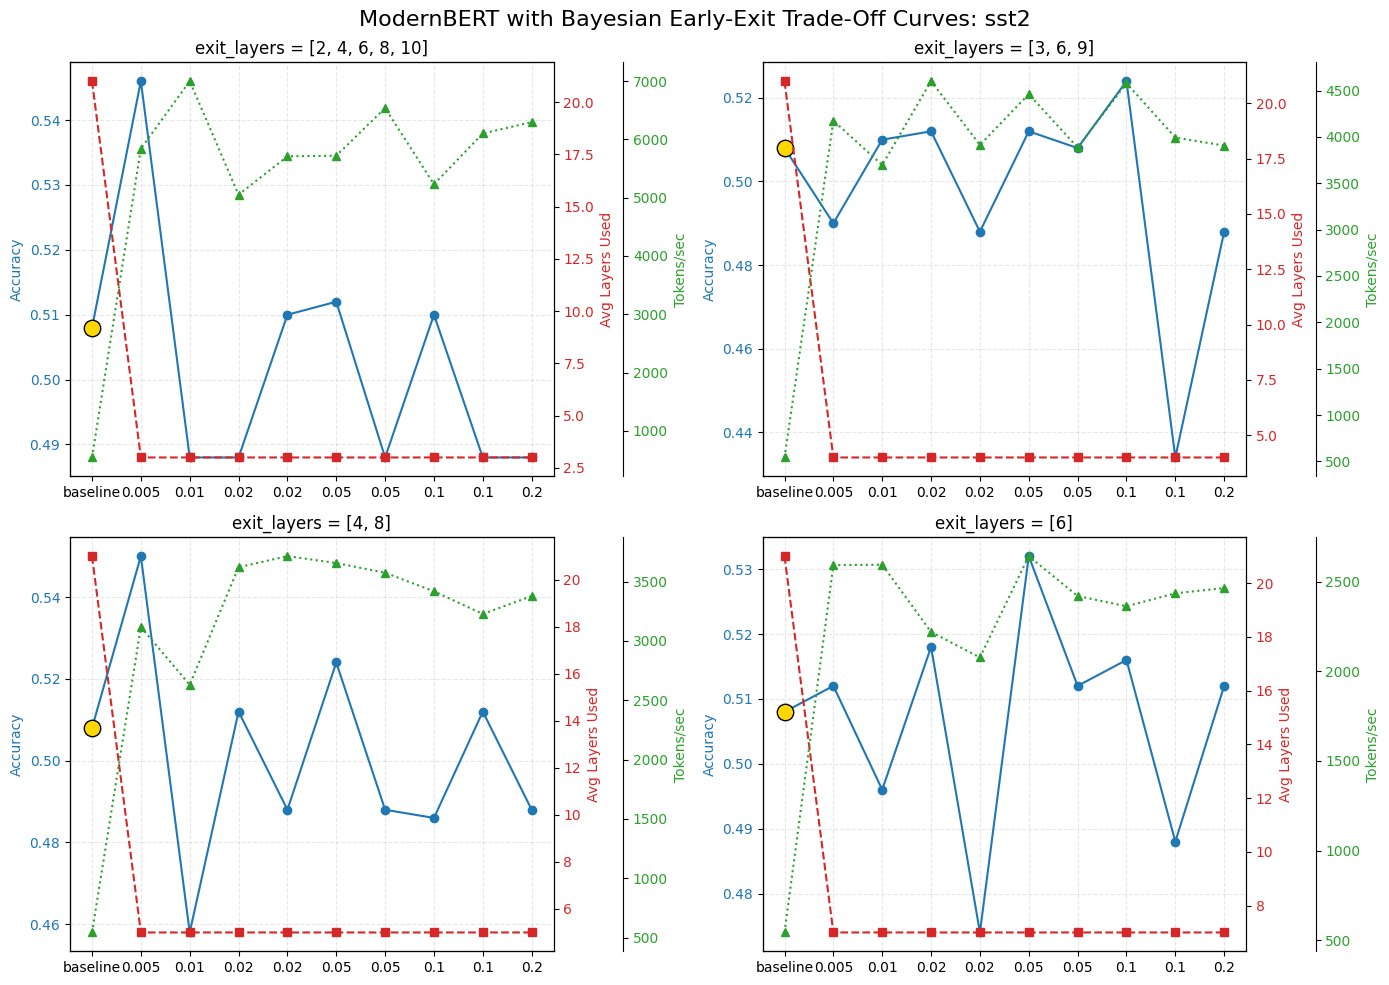

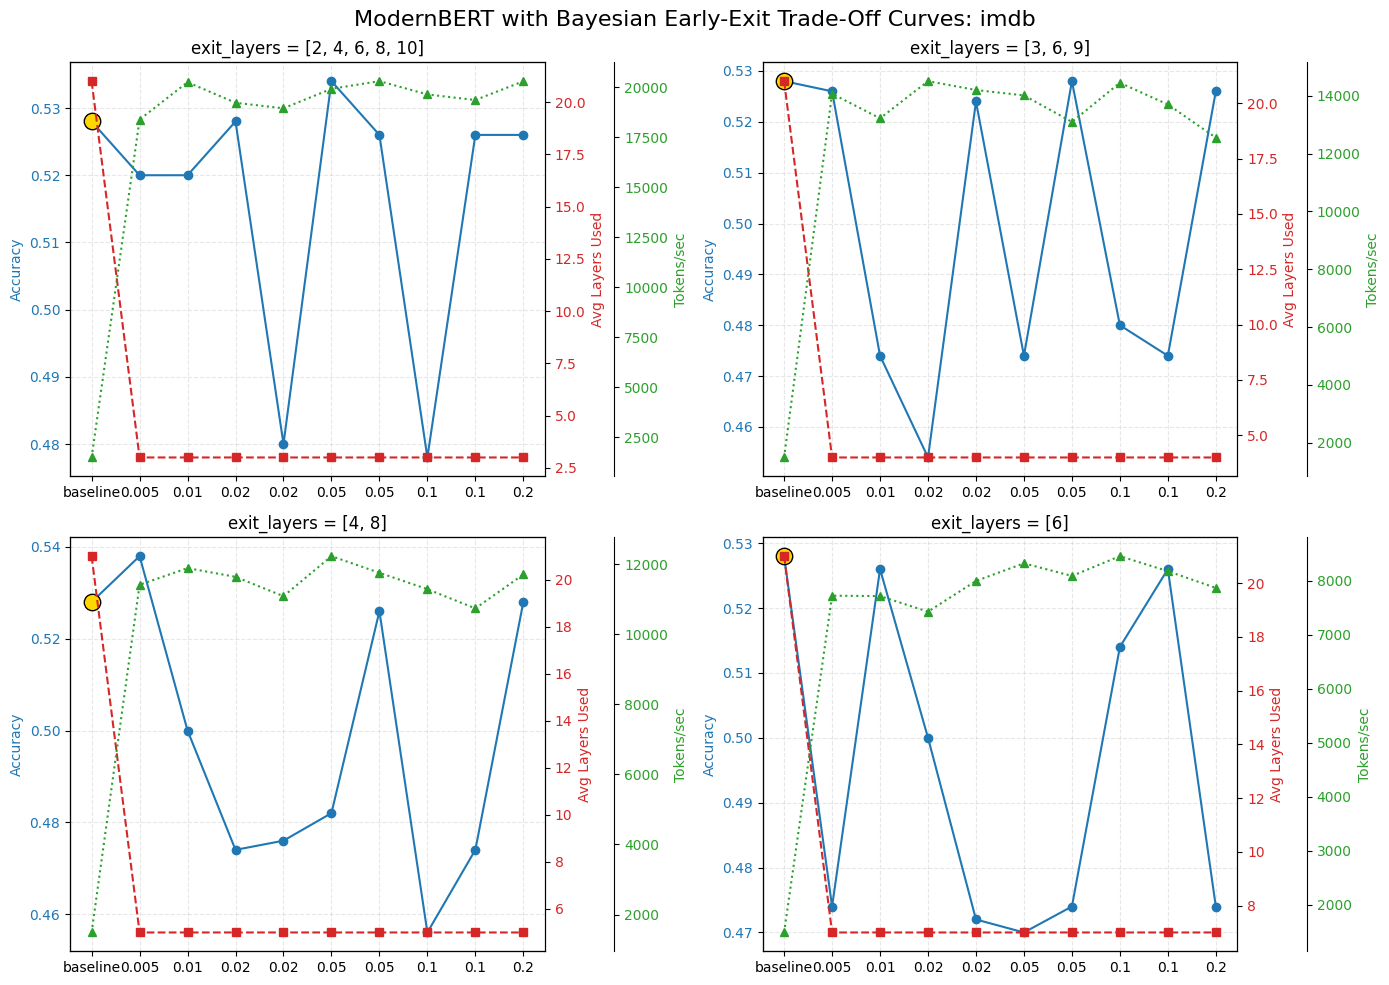

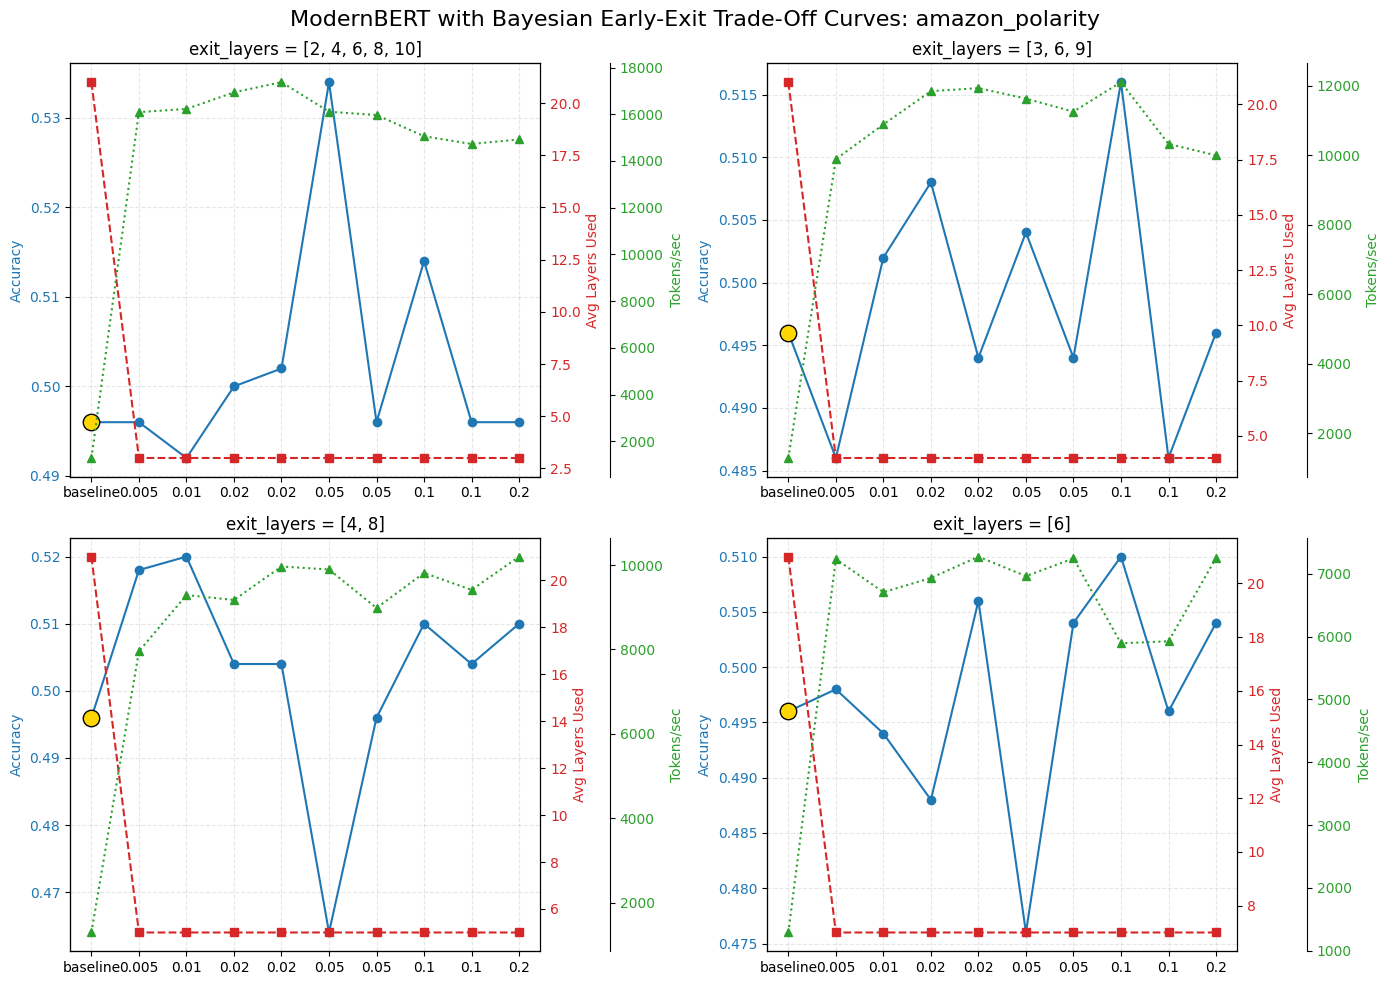

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

df2 = df.copy()

# Replace NaN thresholds with 'baseline'
df2['threshold'] = df2['threshold'].apply(
    lambda x: "baseline" if pd.isna(x) else x
)

# Convert exit_layers list → string for grouping
df2['exit_layers_str'] = df2['exit_layers'].apply(lambda x: str(x))

datasets = df2['dataset'].unique()

for ds in datasets:

    df_ds = df2[df2['dataset'] == ds]

    # Get all exit_layers configs EXCEPT baseline
    exit_configs = sorted(df_ds['exit_layers_str'].unique())
    exit_configs = [cfg for cfg in exit_configs if cfg != "nan"]

    # Only keep configs that are real lists (not baseline)
    # ensure exactly 4 for plotting (or fewer → still works)
    exit_configs = exit_configs[:4]

    # Prepare 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Extract baseline row(s)
    df_base = df_ds[df_ds['mode'] == "baseline"]

    # ---------- LOOP OVER EXIT CONFIGS ----------
    for idx, exit_cfg in enumerate(exit_configs):

        ax = axes[idx]

        # Subset for this exit layers
        df_sub = df_ds[df_ds['exit_layers_str'] == exit_cfg]

        ###########################################
        # 1) Extract values (early-exit run)
        ###########################################
        # Early exit values
        thresholds = df_sub['threshold'].tolist()
        scores     = df_sub['score'].tolist()
        layers     = df_sub['avg_layers_used'].tolist()
        tps        = df_sub['tokens_per_sec'].tolist()
        
        # Add baseline explicitly (first element)
        if not df_base.empty:
            thresholds = ["baseline"] + thresholds
            scores     = [df_base['score'].iloc[0]] + scores
            layers     = [df_base['avg_layers_used'].iloc[0]] + layers
            tps        = [df_base['tokens_per_sec'].iloc[0]] + tps


        ###########################################
        # 2) Extract baseline values
        ###########################################
        base_thresholds = df_base['threshold'].tolist()
        base_scores     = df_base['score'].tolist()
        base_layers     = df_base['avg_layers_used'].tolist()
        base_tps        = df_base['tokens_per_sec'].tolist()

        # ---- Sorting helper: baseline always first ----
        def sort_key(x):
            return -1 if x == "baseline" else float(x)

        sorted_idx = sorted(
            range(len(thresholds)),
            key=lambda i: sort_key(thresholds[i])
        )

        thresholds = [thresholds[i] for i in sorted_idx]
        scores     = [scores[i]     for i in sorted_idx]
        layers     = [layers[i]     for i in sorted_idx]
        tps        = [tps[i]        for i in sorted_idx]

        x_pos = np.arange(len(thresholds))

        ################################################
        # ---- PLOTS (same style as your original) ----
        ################################################
        ax1 = ax

        # Accuracy curve
        ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
        ax1.set_ylabel("Accuracy", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        # Plot baseline point in gold
        for i, th in enumerate(thresholds):
            if th == "baseline":
                ax1.scatter(
                    x_pos[i], scores[i],
                    color="gold", s=140, edgecolor="black", zorder=6,
                    label="Baseline"
                )

        # Avg layers
        ax2 = ax1.twinx()
        ax2.plot(
            x_pos, layers,
            marker="s", linestyle="--",
            color="tab:red", label="Layers Used"
        )
        ax2.set_ylabel("Avg Layers Used", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        # Tokens/sec
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 50))
        ax3.plot(
            x_pos, tps,
            marker="^", linestyle=":",
            color="tab:green", label="Tokens/sec"
        )
        ax3.set_ylabel("Tokens/sec", color="tab:green")
        ax3.tick_params(axis="y", labelcolor="tab:green")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(thresholds)
        ax.set_title(f"exit_layers = {exit_cfg}")

        ax.grid(True, linestyle="--", alpha=0.3)

    # ------- FIGURE TITLE -------
    fig.suptitle(f"ModernBERT with Bayesian Early-Exit Trade-Off Curves: {ds}", fontsize=16)
    plt.tight_layout()
    plt.show()